In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import ToTensor
from cs_6804_project.src.torch_cloudnet.model import CloudNet
from cs_6804_project.src.torch_cloudnet.dataset import CloudDataset
from cs_6804_project.src.keras_cloudnet.utils import get_input_image_names
from cs_6804_project.src.keras_cloudnet.augmentation import (flipping_img_and_msk, rotate_cclk_img_and_msk,
                                                             rotate_clk_img_and_msk, zoom_img_and_msk)
from cs_6804_project.src.torch_cloudnet.losses import jaccard_coef

In [2]:
# Paths to data
GLOBAL_PATH = "D:/38-Cloud/"
TRAIN_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_training')
TEST_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_test')
LOG_FOLDER = os.path.join(GLOBAL_PATH, 'experiments')

# Set params
in_rows = 192
in_cols = 192
num_of_channels = 4
num_of_classes = 1
starting_learning_rate = 1e-4
end_learning_rate = 1e-8
max_num_epochs = 2000  # just a huge number. The actual training should not be limited by this value
val_ratio = 0.2
patience = 15
decay_factor = 0.7
batch_sz = 12
max_bit = 65535  # maximum gray level in landsat 8 images
experiment_name = "Cloud-Net"
weights_path = os.path.join(GLOBAL_PATH, experiment_name + '.h5')
train_resume = False

In [3]:
# Get input/target image names
train_patches_csv_name = 'training_patches_38-cloud_nonempty.csv'
df_train_img = pd.read_csv(os.path.join(GLOBAL_PATH, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

100%|██████████████████████████████████████████████████████████████████████████| 5155/5155 [00:00<00:00, 468690.65it/s]


In [4]:
# Split data into training and validation
train_img_split, val_img_split, train_msk_split, val_msk_split = train_test_split(train_img, train_msk,
                                                                                   test_size=val_ratio,
                                                                                   random_state=42, shuffle=True)

In [5]:
# Get Datasets from file names
ds_train = CloudDataset(train_img_split, train_msk_split, in_rows, in_cols, max_bit, transform=True)
ds_val = CloudDataset(val_img_split, val_msk_split, in_rows, in_cols, max_bit)

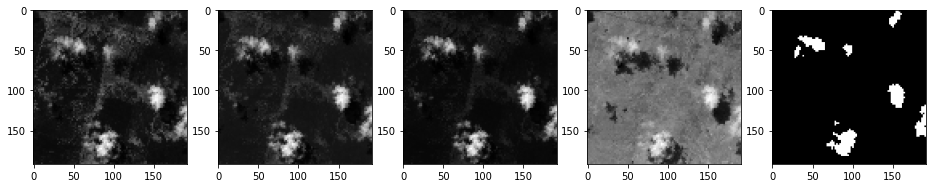

In [6]:
# Visualize random datapoint
idx_viz = np.random.randint(len(ds_train), dtype=int)
data_viz = ds_train[idx_viz]
img_viz = data_viz[0]
msk_viz = data_viz[1]

fig = plt.figure(figsize=(16,9))
plt.subplot(1, 5, 1)
plt.imshow(img_viz[0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(img_viz[1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(img_viz[2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(img_viz[3], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(msk_viz[0], cmap='gray')
plt.show()

In [7]:
# Get DataLoaders from Datasets
dl_train = DataLoader(ds_train, batch_size=batch_sz, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_sz, shuffle=True)

In [8]:
# Define model
model = CloudNet(1)
optimizer = optim.Adam(model.parameters(), lr=starting_learning_rate)
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define TensorBoard
tb = SummaryWriter("experiment_initial")

In [9]:
%load_ext tensorboard

In [10]:
# Train model
model.train()
steps = 100000
for i, data in enumerate(dl_train):
    # Load data onto device
    images, target = data
    images = images.to(device)
    target = target.to(device)
    
    # Forward pass and loss calculation
    out = model(images)
    loss = jaccard_coef(target, out)
    
    # Backward pass and model update
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Track training performance
    if i % 100 == 99:
        tb.add_scalar('jaccard_loss', loss, i)
        print(f"Step: {i+1}")
    if i == (steps - 1):
        break
tb.close()

RuntimeError: Given groups=1, weight of size [32, 16, 3, 3], expected input[12, 4, 192, 192] to have 16 channels, but got 4 channels instead

In [ ]:
% tensorboard --logdir LOG_FOLDER